In [1]:
import scikitplot as skplt
from imblearn.over_sampling import SMOTE
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import sys
np.set_printoptions(suppress=True, threshold=sys.maxsize)
plt.style.use('ggplot')
# Using panda.io to read the dataset
unprocessed_data_X = pd.read_csv("heartdisease300.csv")
unprocessed_data_y = unprocessed_data_X.loc[:, "target"]

In [2]:
# Feature Selection using a chi-squared scoring function
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
feature_selection = SelectKBest(chi2, k=13)
feature_selection_data = feature_selection.fit_transform(
    unprocessed_data_X, unprocessed_data_y)
processed_data_X = feature_selection_data[:, :-1]
processed_data_Y = feature_selection_data[:, 12]
# Hyperparameters: score_func - chi2
# This feature had the lowest chi2 scores and will be excluded:
# fasting blood sugar > 120 mg/dl

In [3]:
# SMOTE
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
smote_processed_data_X, smote_processed_data_Y = SMOTE(
).fit_resample(processed_data_X, processed_data_Y)
# Hyperparameters: sampling_strategy - auto = resampling only the minority class
# k_neighbors - default = 5
# ??? new entries were created by SMOTE to oversample the minority

In [4]:
# 70%/30% Training Test Split
processed_train_X, processed_test_X, processed_train_Y, processed_test_Y = train_test_split(
    processed_data_X, processed_data_Y, test_size=0.3, random_state=1)
smote_train_X, smote_test_X, smote_train_Y, smote_test_Y = train_test_split(
    smote_processed_data_X, smote_processed_data_Y, test_size=0.3, random_state=1)
# Hyperparameters: test_size - 30
# train_size - 70
# shuffle default = True

<AxesSubplot:xlabel='3', ylabel='4'>

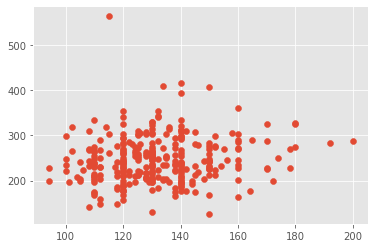

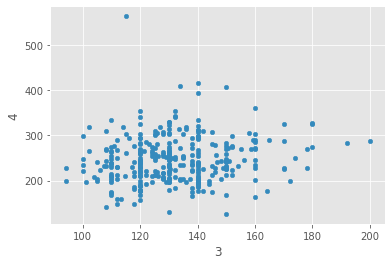

In [5]:
# Scatterplot for unprocessed data
# print(unprocessed_data_X)
g1 = unprocessed_data_X.loc[:, "age":"target"]
plt.scatter('trestbps', 'chol', data=g1)

# Scatterplot for SMOTE treated data
# Convert SMOTE-treated data numpy array to DataFrame to use .loc
smoteDF = pd.DataFrame(smote_processed_data_X)
smoteDF.to_csv("SMOTEData.csv")

# print(smoteDF)
g2 = smoteDF.loc[1025:1051, :]  # New data from SMOTE
# print (g2)
smoteDF.plot(x=3, y=4, kind='scatter')

In [6]:
# RF
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

random_forest = RandomForestClassifier()

# RF w/ SMOTE
random_forest_smote = random_forest.fit(smote_train_X, smote_train_Y)
random_forest_smote_cv = cross_validate(
    random_forest_smote, smote_train_X, smote_train_Y)
print('---RANDOM FOREST---')
print('Random Forest w/ SMOTE Training Set Accuracy: ', end="")
print(np.mean(random_forest_smote_cv['test_score']))
print('Random Forest w/ SMOTE Test Set Accuracy: ', end="")
print(random_forest_smote.score(smote_test_X, smote_test_Y))

# RF w/o SMOTE
random_forest_processed = random_forest.fit(
    processed_train_X, processed_train_Y)
random_forest_processed_cv = cross_validate(
    random_forest_processed, processed_train_X, processed_train_Y)
print('Random Forest w/o SMOTE Training Accuracy: ', end="")
print(np.mean(random_forest_processed_cv['test_score']))
print('Random Forest w/o SMOTE Test Set Accuracy: ', end="")
print(random_forest_processed.score(processed_test_X, processed_test_Y))

rf_predicted_nosmote = random_forest_processed.predict(processed_test_X)
rf_predicted_smote = random_forest_smote.predict(smote_test_X)

# confusion matrix
print("confusion matrix")
print("\n")
print("without smote")
print("\n")
rf_conf_matrix_nosmote = confusion_matrix(
    processed_test_Y, rf_predicted_nosmote)
print(rf_conf_matrix_nosmote)
print("\n")
print("with smote")
print("\n")
r_conf_matrix_smote = confusion_matrix(smote_test_Y, rf_predicted_smote)
print(r_conf_matrix_smote)

# scores for stat
print("\n")
print("without smote")
print(classification_report(processed_test_Y, rf_predicted_nosmote))
print("with smote")
print(classification_report(smote_test_Y, rf_predicted_smote))

---RANDOM FOREST---
Random Forest w/ SMOTE Training Set Accuracy: 0.8559420289855073
Random Forest w/ SMOTE Test Set Accuracy: 0.8282828282828283
Random Forest w/o SMOTE Training Accuracy: 0.8067552602436322
Random Forest w/o SMOTE Test Set Accuracy: 0.8571428571428571
confusion matrix


without smote


[[43  6]
 [ 7 35]]


with smote


[[48  5]
 [ 3 43]]


without smote
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87        49
         1.0       0.85      0.83      0.84        42

    accuracy                           0.86        91
   macro avg       0.86      0.86      0.86        91
weighted avg       0.86      0.86      0.86        91

with smote
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92        53
         1.0       0.90      0.93      0.91        46

    accuracy                           0.92        99
   macro avg       0.92      0.92      0.92        99
weighted avg    

In [7]:
#Grid Search
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(unprocessed_data_X, unprocessed_data_y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


The best parameters are {'C': 10000.0, 'gamma': 1e-05} with a score of 1.00


In [8]:
#SVM

svm = SVC(kernel='rbf', gamma=0.00001,C=10000)

# SVM w/ SMOTE
svm_smote=svm.fit(smote_train_X, smote_train_Y)
svm_predicted_smote = svm_smote.predict(smote_test_X)
print('---SUPPORT VECTOR MACHINE---')
print('SVM w/ SMOTE Test Set Accuracy: ', end="")
print(svm_smote.score(smote_test_X, smote_test_Y))
print('SVM w/ SMOTE Training Set Accuracy: ', end="")
print(svm_smote.score(smote_train_X, smote_train_Y))

# SVM w/o SMOTE
svm_nosmote = svm.fit(processed_data_X, processed_data_Y)
svm_predicted_nosmote = svm_nosmote.predict(processed_test_X)

print('SVM w/o SMOTE Test Set Accuracy: ', end="")
print(svm_nosmote.score(processed_test_X, processed_test_Y))
print('SVM w/o SMOTE Training Set Accuracy: ', end="")
print(svm_nosmote.score(processed_train_X, processed_train_Y))
print()

#confusion matrix
print("confusion matrix")
print("\n")
print("without smote")
print("\n")
svc_conf_matrix_nosmote = confusion_matrix(processed_test_Y,svm_predicted_nosmote)
print(svc_conf_matrix_nosmote)
print("\n")
print("with smote")
print("\n")
svc_conf_matrix_smote = confusion_matrix(smote_test_Y,svm_predicted_smote)
print(svc_conf_matrix_smote)

#scores for stat
print("\n")
print("without smote")
print(classification_report(processed_test_Y,svm_predicted_nosmote))
print("with smote")
print(classification_report(smote_test_Y,svm_predicted_smote))



---SUPPORT VECTOR MACHINE---
SVM w/ SMOTE Test Set Accuracy: 0.7878787878787878
SVM w/ SMOTE Training Set Accuracy: 0.8733624454148472
SVM w/o SMOTE Test Set Accuracy: 0.8791208791208791
SVM w/o SMOTE Training Set Accuracy: 0.8490566037735849

confusion matrix


without smote


[[45  4]
 [ 7 35]]


with smote


[[41 12]
 [ 9 37]]


without smote
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89        49
         1.0       0.90      0.83      0.86        42

    accuracy                           0.88        91
   macro avg       0.88      0.88      0.88        91
weighted avg       0.88      0.88      0.88        91

with smote
              precision    recall  f1-score   support

         0.0       0.82      0.77      0.80        53
         1.0       0.76      0.80      0.78        46

    accuracy                           0.79        99
   macro avg       0.79      0.79      0.79        99
weighted avg       0.79      0.79      0.7


Validation accuracy for Ensembling w/ SMOTE: 0.7889473684210526


C:\Users\jim\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jim\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jim\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\jim\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\jim\anaconda3\lib\site-packages\sklearn\ensemble\_voting.py", line 341, in predict
    maj = np.argmax(self.predict_proba(X), axis=1)
  File "C:\Users\jim\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs

Best parameters for Ensembling + SMOTE: {'voting': 'hard', 'weights': (1, 1)}


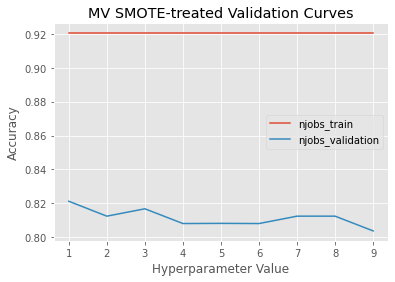


Validation accuracy for Ensembling w/o SMOTE: 0.8140350877192983


C:\Users\jim\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jim\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jim\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\jim\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\jim\anaconda3\lib\site-packages\sklearn\ensemble\_voting.py", line 341, in predict
    maj = np.argmax(self.predict_proba(X), axis=1)
  File "C:\Users\jim\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs

Best parameters for Ensembling w/o SMOTE: {'voting': 'hard', 'weights': (1, 1)}


In [ ]:
#TODO: MV

# estimators for ensembling MV
estimators = [('RandomForest', random_forest), ('SVM', svm)]
ensemble_smote = VotingClassifier(estimators, voting='hard', weights=[
                                  1, 1])  # hard voting, because we are doing MV
ensemble_smote.fit(smote_test_X, smote_test_Y)

results_smote = model_selection.cross_val_score(
    ensemble_smote, smote_test_X, smote_test_Y, scoring='accuracy')
print()
print("Validation accuracy for Ensembling w/ SMOTE: ", end="")
print(results_smote.mean())

# # TODO: Adjust MV Hyperparameters
# Exhaustive Grid Search with Cross Validation for Optimal Hyperparameters

params = {'voting': ['soft', 'hard'],
          'weights': [(1, 1)]}

grid_smote = GridSearchCV(estimator=ensemble_smote, param_grid=params, cv=2)

grid_smote.fit(smote_train_X, smote_train_Y)
print("Best parameters for Ensembling + SMOTE: ", end="")
print(grid_smote.best_params_)

#{'voting': 'hard', 'weights': (1, 1)}

# validation graph
param_range = np.arange(0, 10, 1, dtype=int)

train_scores, test_scores = validation_curve(
    ensemble_smote,
    smote_train_X,
    smote_train_Y,
    param_name="n_jobs",
    param_range=param_range,
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_scores_mean,
         label="njobs_train")
plt.plot(param_range, test_scores_mean, label="njobs_validation")
plt.title("MV SMOTE-treated Validation Curves")
plt.xlabel("Hyperparameter Value")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

ensemble_proc = VotingClassifier(estimators, voting='hard', weights=[
                                 1, 1])  # hard voting, because we are doing MV
ensemble_proc.fit(processed_test_X, processed_test_Y)

results_proc = model_selection.cross_val_score(
    ensemble_proc, processed_test_X, processed_test_Y, scoring='accuracy')
print()
print("Validation accuracy for Ensembling w/o SMOTE: ", end="")
print(results_proc.mean())


# # TODO: Adjust MV Hyperparameters
# Exhaustive Grid Search with Cross Validation for Optimal Hyperparameters
params = {'voting': ['soft', 'hard'],
          'weights': [(1, 1)]}

grid_proc = GridSearchCV(estimator=ensemble_proc, param_grid=params, cv=2)

grid_proc.fit(processed_train_X, processed_train_Y)
print("Best parameters for Ensembling w/o SMOTE: ", end="")
print(grid_proc.best_params_)

#{'voting': 'hard', 'weights': (1, 1)}

param_range = np.arange(1, 10, 1, dtype=int)
train_scores, test_scores = validation_curve(
    ensemble_proc,
    processed_test_X,
    processed_test_Y,
    param_name="n_jobs",
    param_range=param_range,
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="train", color="blue")
plt.plot(param_range, test_scores_mean, label="test", color="red")

plt.legend()
plt.show()
y_pred = ensemble_proc.predict(processed_test_X)
print(classification_report(processed_test_Y, y_pred))

skplt.metrics.plot_confusion_matrix(processed_test_Y, y_pred, figsize=(10, 8))
plt.show()
# confusion matrix
print("confusion matrix")
print("\n")
print("without smote")
print("\n")
y_proc_pred = ensemble_proc.predict(processed_test_X)
ensemble_matrix_proc = confusion_matrix(processed_test_Y, y_proc_pred)
print(ensemble_matrix_proc)
print("\n")
print("with smote")
print("\n")
y_smote_pred = ensemble_smote.predict(smote_test_X)
ensemble_matrix_smote = confusion_matrix(smote_test_Y, y_smote_pred)
print(ensemble_matrix_smote)

# scores for stat
print("\n")
print("without smote")
print(classification_report(processed_test_Y, y_proc_pred))
print("with smote")
print(classification_report(smote_test_Y, y_smote_pred))

# # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
# # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# # Refer to MV documentation for possible parameter values
